<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import torchvision

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

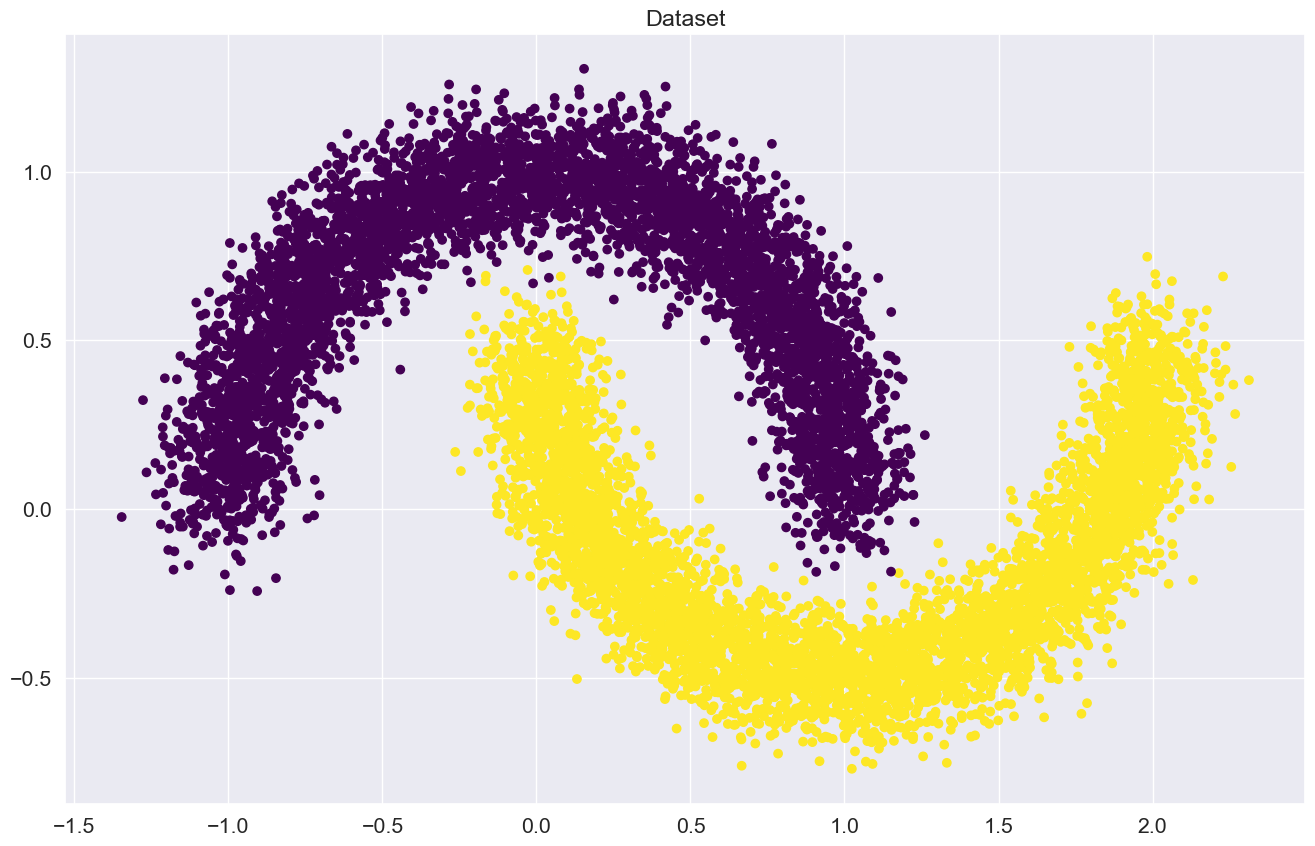

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.from_numpy(X_train) # YOUR CODE GOES HERE
y_train_t = torch.from_numpy(y_train) # YOUR CODE GOES HERE
X_val_t = torch.from_numpy(X_val) # YOUR CODE GOES HERE
y_val_t = torch.from_numpy(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features)).float()
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1, out_features))# YOUR CODE GOES HERE

    def forward(self, x):
        x = x.float() @ self.weights  # YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

- Ответом на вопрос является число весов (2 штуки) плюс бейс (1 штука) == 3

In [9]:
linear_regression.__annotations__

{'dump_patches': bool,
 '_version': int,
 'training': bool,
 '_parameters': typing.Dict[str, typing.Optional[torch.nn.parameter.Parameter]],
 '_buffers': typing.Dict[str, typing.Optional[torch.Tensor]],
 '_non_persistent_buffers_set': typing.Set[str],
 '_backward_pre_hooks': typing.Dict[int, typing.Callable],
 '_backward_hooks': typing.Dict[int, typing.Callable],
 '_is_full_backward_hook': typing.Optional[bool],
 '_forward_hooks': typing.Dict[int, typing.Callable],
 '_forward_hooks_with_kwargs': typing.Dict[int, bool],
 '_forward_pre_hooks': typing.Dict[int, typing.Callable],
 '_forward_pre_hooks_with_kwargs': typing.Dict[int, bool],
 '_state_dict_hooks': typing.Dict[int, typing.Callable],
 '_load_state_dict_pre_hooks': typing.Dict[int, typing.Callable],
 '_state_dict_pre_hooks': typing.Dict[int, typing.Callable],
 '_load_state_dict_post_hooks': typing.Dict[int, typing.Callable],
 '_modules': typing.Dict[str, typing.Optional[ForwardRef('Module')]],
 'call_super_init': bool,
 'forward':

In [10]:
linear_regression._parameters

OrderedDict([('weights',
              Parameter containing:
              tensor([[-0.3595],
                      [-0.6184]], requires_grad=True)),
             ('bias_term',
              Parameter containing:
              tensor([[-1.0587]], requires_grad=True))])

In [11]:
from torchinfo import summary

print(summary(linear_regression, (1, 2)))
None

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


C:\Users\dimka\PycharmProjects\DeepLEarningSchool_MFTI\venv\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\dimka\PycharmProjects\DeepLEarningSchool_MFTI\venv\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [54]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch.float()) # YOUR CODE. Use linear_regression to get outputs
        # print(outp.flatten().shape, y_batch.view(-1, 1).shape)
        loss = loss_function(outp.flatten().float(), y_batch.float()) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        probabilities = torch.nn.functional.softmax(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

C:\Users\dimka\AppData\Local\Temp\ipykernel_1140\1134074144.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(outp) # YOUR CODE. Compute probabilities


Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.546875
Iteration: 200
Batch accuracy: 0.4609375
Iteration: 300
Batch accuracy: 0.578125
Iteration: 400
Batch accuracy: 0.4765625
Iteration: 500
Batch accuracy: 0.4921875
Iteration: 600
Batch accuracy: 0.40625

Iteration: 696.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 877 (каждый раз разная поэтому если не то число стоит просто посмотрите наверх 0o0)

### Визуализируем результаты

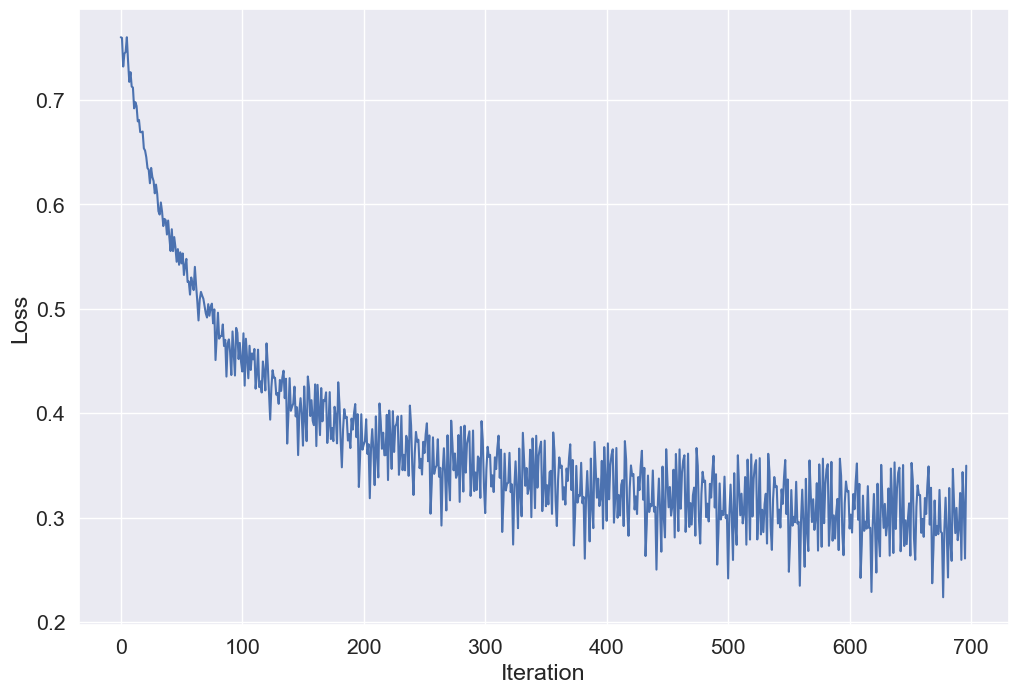

In [55]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

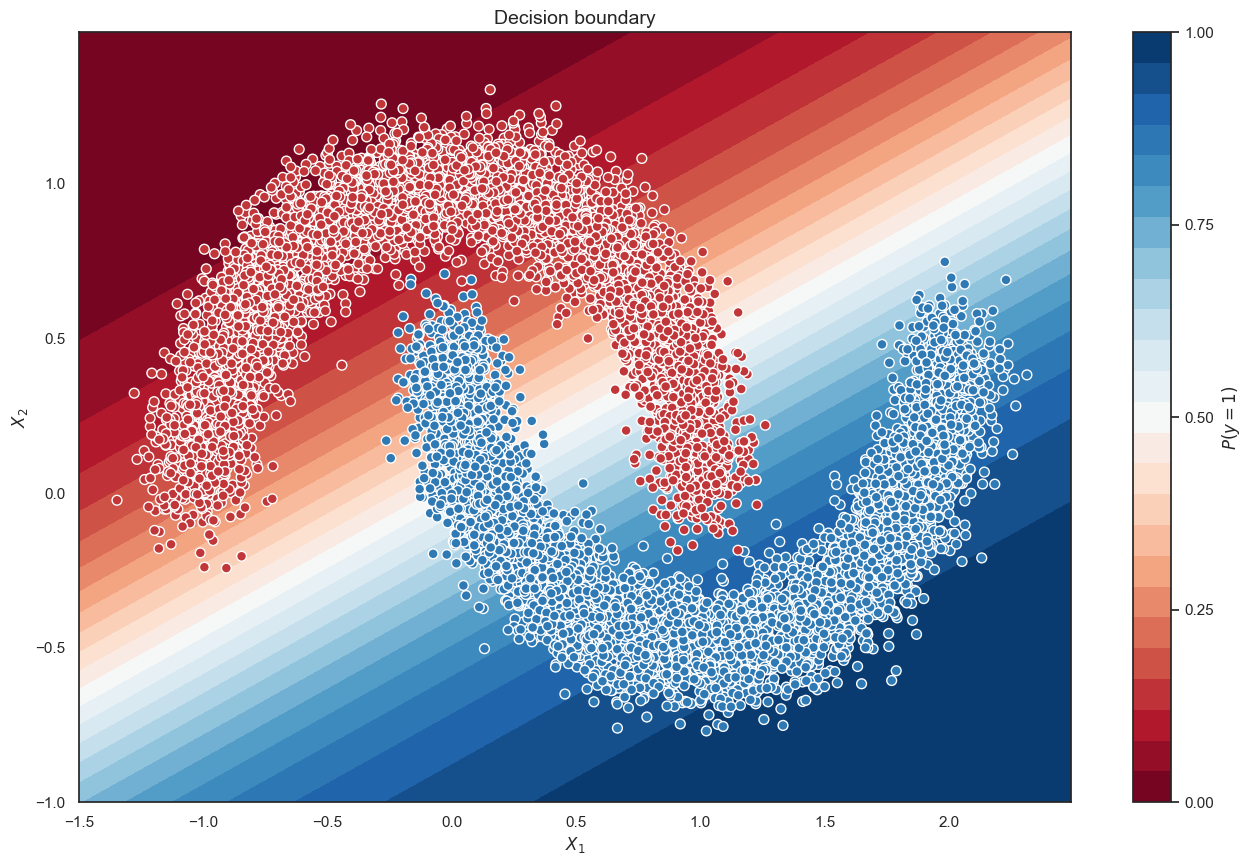

In [56]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [12]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:

        outp = model(x_batch)
        probabilities = torch.nn.functional.softmax(outp)
        preds = (probabilities > 0.5).type(torch.long) #YOUR CODE. Compute predictions

        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [58]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
pred =  predict(val_dataloader, linear_regression)
print(accuracy_score(pred, y_val))
None

0.4912


C:\Users\dimka\AppData\Local\Temp\ipykernel_1140\3796049699.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(outp)


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.4912 удивительно

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [13]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

In [14]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True) # YOUR CODE GOES HERE

valid_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [15]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [16]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),

    #YOUR CODE. Add layers to your sequential class
    nn.Linear(in_features=784, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=10),
    nn.Softmax()
)

In [17]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [65]:
# example
a = np.array([0, 1, 1])
b = np.array( [0, 1, 0])
res = a==b
print(res.sum())

2


### Задание. Дополните цикл обучения.

In [19]:
# НЕ ЗАПУСКАТЬ ЛИШНИЙ РАЗ
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        all_pred = 0

        for x_batch, y_batch in dataloader:
            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(-1)

            epoch_correct += (y_batch == preds).sum() # YOUR CODE
            epoch_all += dataloader.batch_size        # YOUR CODE

            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


C:\Users\dimka\PycharmProjects\DeepLEarningSchool_MFTI\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1
Loader: train. Accuracy: 0.8120999932289124
Loader: valid. Accuracy: 0.8346999883651733
Epoch: 2
Loader: train. Accuracy: 0.8372666835784912
Loader: valid. Accuracy: 0.885200023651123
Epoch: 3
Loader: train. Accuracy: 0.8258333206176758
Loader: valid. Accuracy: 0.8770999908447266
Epoch: 4
Loader: train. Accuracy: 0.8321666717529297
Loader: valid. Accuracy: 0.8787999749183655
Epoch: 5
Loader: train. Accuracy: 0.8324666619300842
Loader: valid. Accuracy: 0.7610999941825867
Epoch: 6
Loader: train. Accuracy: 0.8241999745368958
Loader: valid. Accuracy: 0.7049000263214111
Epoch: 7
Loader: train. Accuracy: 0.814383327960968
Loader: valid. Accuracy: 0.784600019454956
Epoch: 8
Loader: train. Accuracy: 0.805400013923645
Loader: valid. Accuracy: 0.7942000031471252
Epoch: 9
Loader: train. Accuracy: 0.8108500242233276
Loader: valid. Accuracy: 0.8115000128746033
Epoch: 10
Loader: train. Accuracy: 0.822616696357727
Loader: valid. Accuracy: 0.8695999979972839


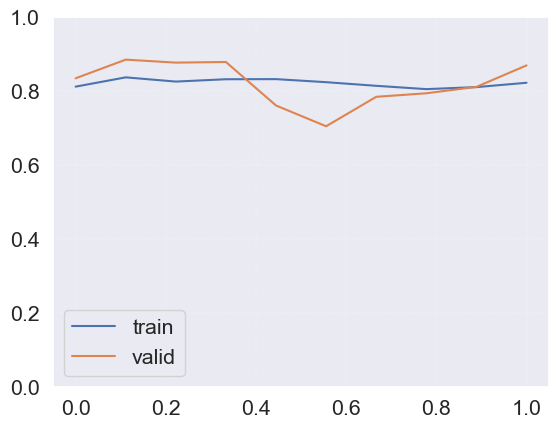

In [20]:
plt.plot(np.linspace(0,1,len(accuracy["train"])),
         accuracy["train"],
         np.linspace(0,1,len(accuracy["valid"])),
         accuracy["valid"])
plt.legend(["train","valid"])
plt.grid(linewidth=0.2, linestyle="--")
plt.ylim([0, 1])
None

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [21]:
elu_accuracy = accuracy["valid"]

In [22]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def fit(model, loaders, criterion, optimizer, max_epochs = 10):
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)

                epoch_correct += (y_batch == preds).sum()
                epoch_all += dataloader.batch_size

                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]

In [23]:
def test_activation_function(activation):
    # create model
    model = nn.Sequential(
        nn.Flatten(),

        #YOUR CODE. Add layers to your sequential class
        nn.Linear(in_features=784, out_features=128),
        activation(),
        nn.Linear(in_features=128, out_features=128),
        activation(),
        nn.Linear(in_features=128, out_features=10),
        nn.Softmax()
    )

    return fit(model=model,
               criterion = nn.CrossEntropyLoss(),
               optimizer = torch.optim.Adam(model.parameters()),
               loaders=loaders,
               max_epochs=10)

- Хочу добавить, что не используя функции активации у нас практически остается не несколько, а один линейный слой, потому что несколько переменоженных матриц == одна большая матрица

In [24]:
plain_accuracy = test_activation_function(Identical)

Epoch: 1
Loader: train. Accuracy: 0.5891833305358887
Loader: valid. Accuracy: 0.6396999955177307
Epoch: 2
Loader: train. Accuracy: 0.5994333624839783
Loader: valid. Accuracy: 0.7059999704360962
Epoch: 3
Loader: train. Accuracy: 0.5322999954223633
Loader: valid. Accuracy: 0.23229999840259552
Epoch: 4
Loader: train. Accuracy: 0.5663333535194397
Loader: valid. Accuracy: 0.5383999943733215
Epoch: 5
Loader: train. Accuracy: 0.5739166736602783
Loader: valid. Accuracy: 0.6359000205993652
Epoch: 6
Loader: train. Accuracy: 0.6642500162124634
Loader: valid. Accuracy: 0.7353000044822693
Epoch: 7
Loader: train. Accuracy: 0.6151166558265686
Loader: valid. Accuracy: 0.6359000205993652
Epoch: 8
Loader: train. Accuracy: 0.6313166618347168
Loader: valid. Accuracy: 0.6729999780654907
Epoch: 9
Loader: train. Accuracy: 0.5912833213806152
Loader: valid. Accuracy: 0.6412000060081482
Epoch: 10
Loader: train. Accuracy: 0.6131333112716675
Loader: valid. Accuracy: 0.6245999932289124


In [25]:
relu_accuracy = test_activation_function(nn.ReLU) #YOUR CODE

Epoch: 1
Loader: train. Accuracy: 0.8447999954223633
Loader: valid. Accuracy: 0.90829998254776
Epoch: 2
Loader: train. Accuracy: 0.8861166834831238
Loader: valid. Accuracy: 0.8725000023841858
Epoch: 3
Loader: train. Accuracy: 0.8835333585739136
Loader: valid. Accuracy: 0.9071999788284302
Epoch: 4
Loader: train. Accuracy: 0.8897666931152344
Loader: valid. Accuracy: 0.8808000087738037
Epoch: 5
Loader: train. Accuracy: 0.8907333612442017
Loader: valid. Accuracy: 0.8715999722480774
Epoch: 6
Loader: train. Accuracy: 0.8876833319664001
Loader: valid. Accuracy: 0.8639000058174133
Epoch: 7
Loader: train. Accuracy: 0.8906833529472351
Loader: valid. Accuracy: 0.8454999923706055
Epoch: 8
Loader: train. Accuracy: 0.8841500282287598
Loader: valid. Accuracy: 0.9136000275611877
Epoch: 9
Loader: train. Accuracy: 0.8928166627883911
Loader: valid. Accuracy: 0.8698999881744385
Epoch: 10
Loader: train. Accuracy: 0.876966655254364
Loader: valid. Accuracy: 0.9038000106811523


In [26]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU) #YOUR CODE

Epoch: 1
Loader: train. Accuracy: 0.8311333060264587
Loader: valid. Accuracy: 0.850600004196167
Epoch: 2
Loader: train. Accuracy: 0.8568166494369507
Loader: valid. Accuracy: 0.8776999711990356
Epoch: 3
Loader: train. Accuracy: 0.8504166603088379
Loader: valid. Accuracy: 0.8593000173568726
Epoch: 4
Loader: train. Accuracy: 0.8269166946411133
Loader: valid. Accuracy: 0.8255000114440918
Epoch: 5
Loader: train. Accuracy: 0.8422666788101196
Loader: valid. Accuracy: 0.833899974822998
Epoch: 6
Loader: train. Accuracy: 0.8294000029563904
Loader: valid. Accuracy: 0.8167999982833862
Epoch: 7
Loader: train. Accuracy: 0.8196166753768921
Loader: valid. Accuracy: 0.8614000082015991
Epoch: 8
Loader: train. Accuracy: 0.8274666666984558
Loader: valid. Accuracy: 0.7601000070571899
Epoch: 9
Loader: train. Accuracy: 0.8273666501045227
Loader: valid. Accuracy: 0.8126999735832214
Epoch: 10
Loader: train. Accuracy: 0.8123666644096375
Loader: valid. Accuracy: 0.8422999978065491


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

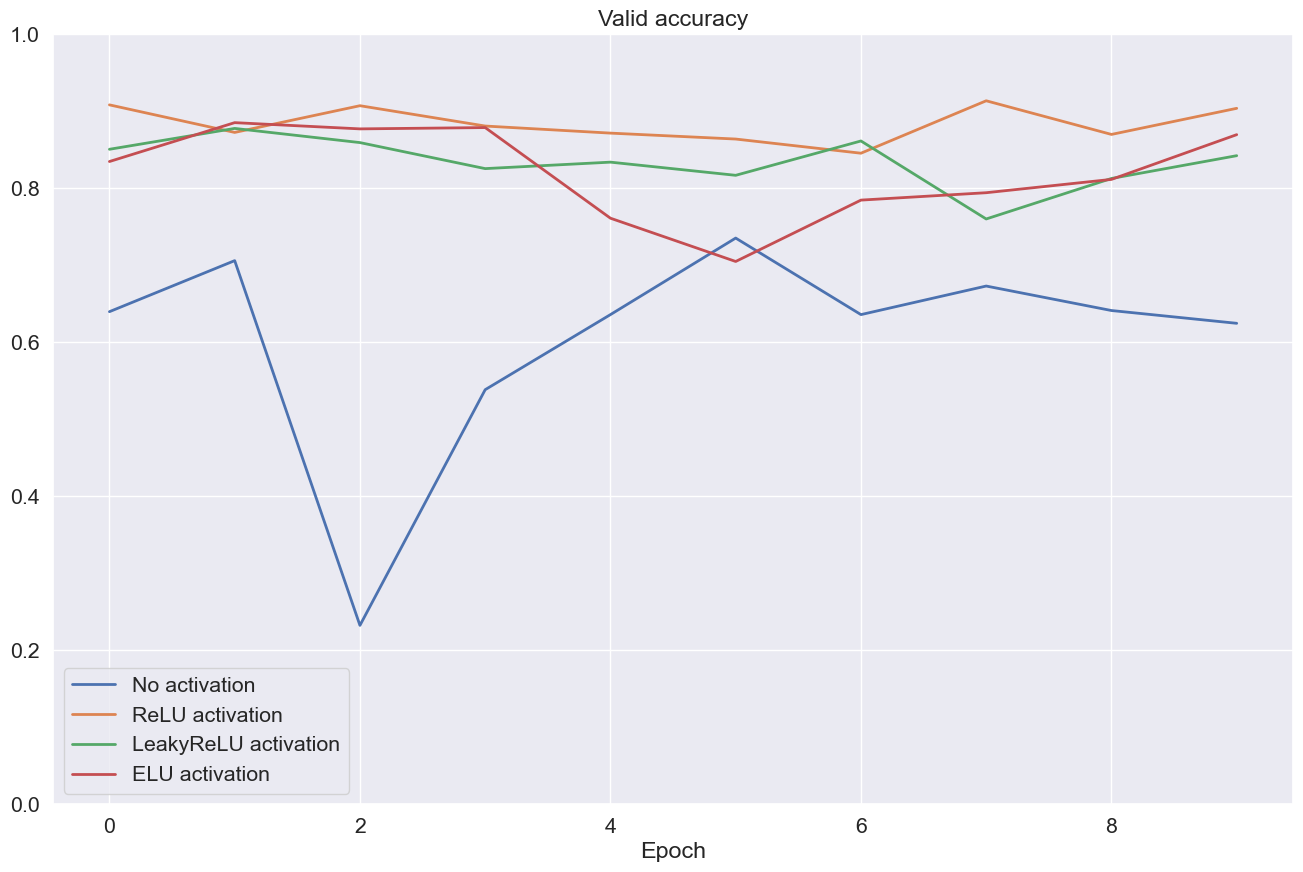

In [27]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.ylim([0,1])
plt.xlabel("Epoch")
plt.show()

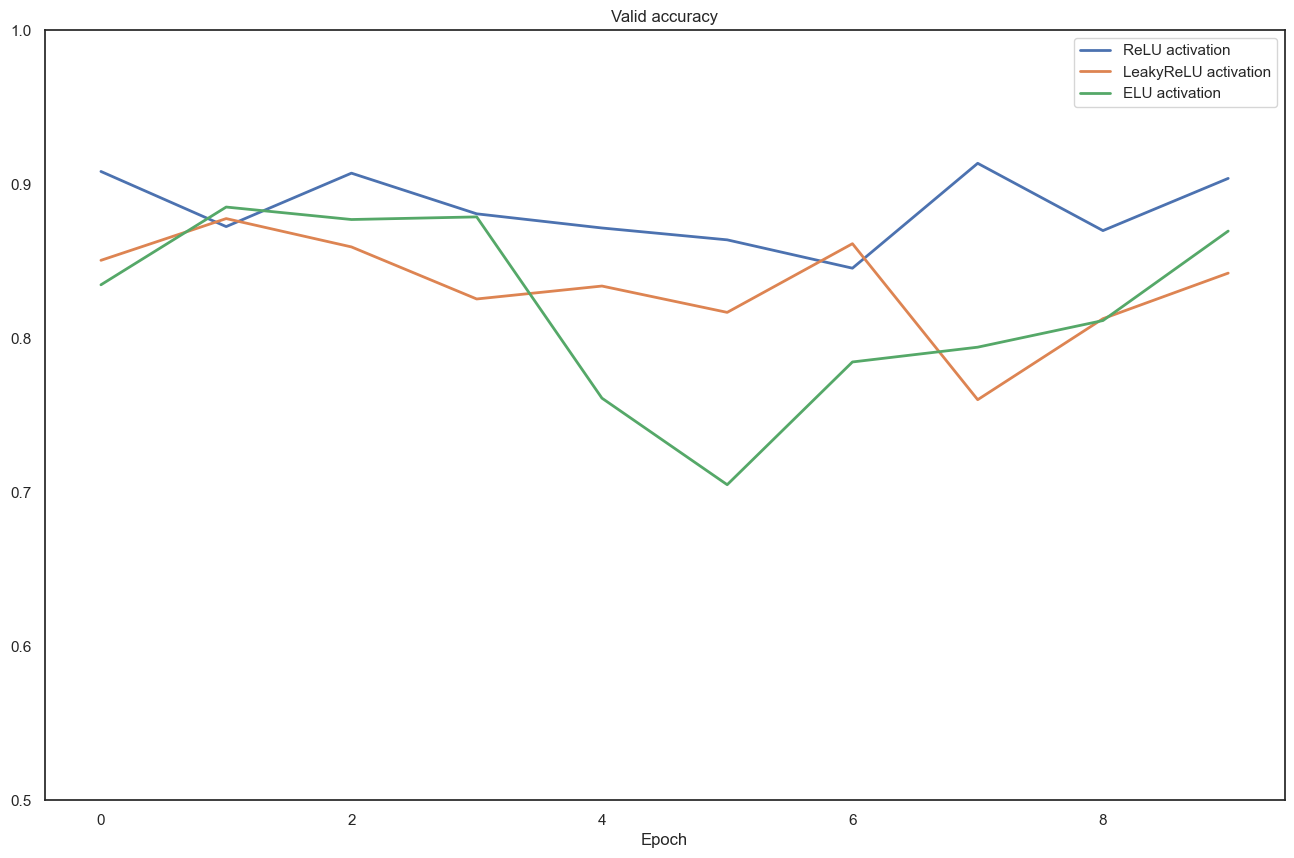

In [36]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.ylim([0.5,1])
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** RelU {max(0,x)}

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [29]:
# !wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg
# сам скачаю =(

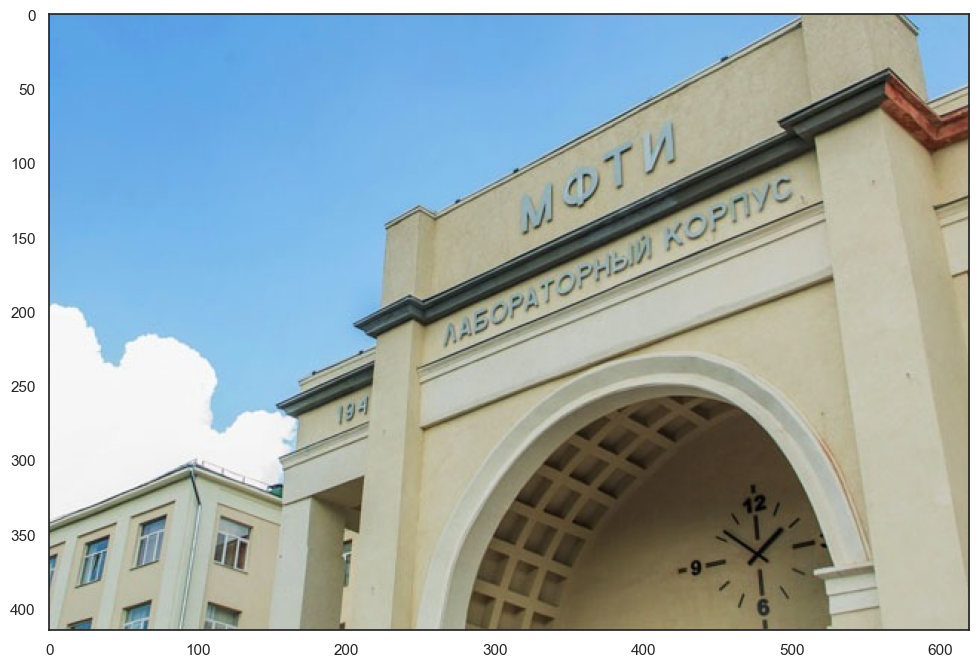

In [30]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [31]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [-6, -3, 0],
    [-3, 0, 3],
    [0, 3, 6]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


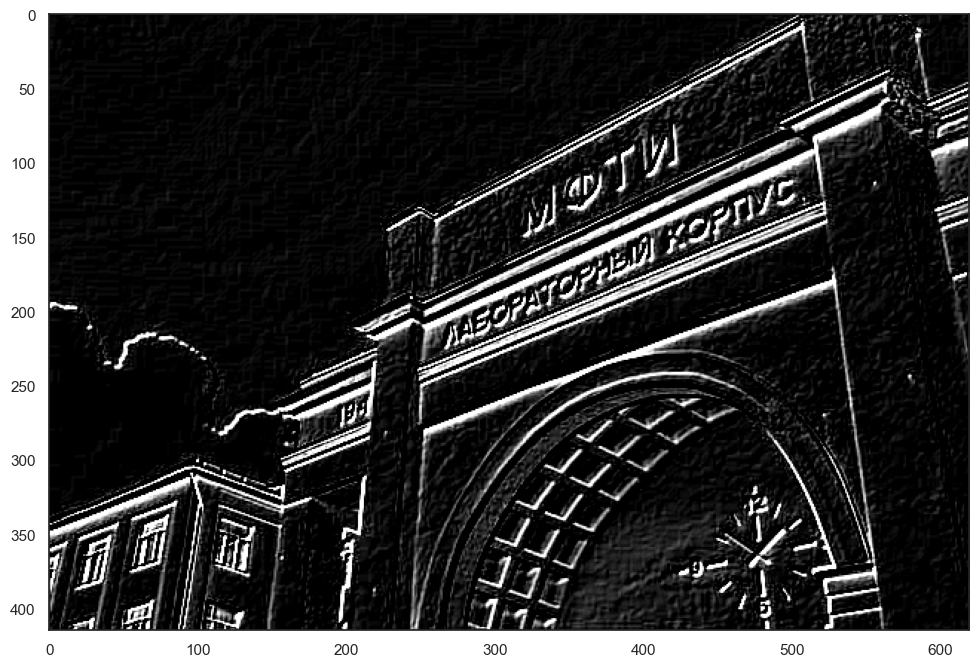

In [32]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е (размытие по Гауссу)
2) Увеличение резкости - Д (Лапласиан)
3) Тождественное преобразование - А
4) Выделение вертикальных границ - В
5) Выделение горизонтальных границ - Б
6) Выделение границ - Г

**Ответ:** Е Д А В Б Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [33]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)  # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features= 400,out_features=120)
        self.fc2 = nn.Linear(in_features= 120,out_features=84)
        self.fc3 = nn.Linear(in_features= 84,out_features=10)

    def forward(self, x):

        # [batch_size, 1, 28, 28]
        x = nn.functional.relu(self.conv1(x))

        # [batch_size, 6, 26, 26]
        x = self.pool1(x)

        # [batch_size, 6, 13, 13]
        x = nn.functional.relu(self.conv2(x))
        x = self.pool2(x)

        # [batch_size, 6, 5, 5]
        x = self.flatten(x)
        # [1600]
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)

        return nn.functional.softmax(x)

In [34]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [35]:
# функция написанная выше
lenet_accuracy = fit(model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    loaders=loaders)

C:\Users\dimka\AppData\Local\Temp\ipykernel_2588\501591177.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


Epoch: 1
Loader: train. Accuracy: 0.9307500123977661
Loader: valid. Accuracy: 0.9642000198364258
Epoch: 2
Loader: train. Accuracy: 0.959683358669281
Loader: valid. Accuracy: 0.954800009727478
Epoch: 3
Loader: train. Accuracy: 0.9592666625976562
Loader: valid. Accuracy: 0.9570000171661377
Epoch: 4
Loader: train. Accuracy: 0.9624333381652832
Loader: valid. Accuracy: 0.9628999829292297
Epoch: 5
Loader: train. Accuracy: 0.9583500027656555
Loader: valid. Accuracy: 0.9165999889373779
Epoch: 6
Loader: train. Accuracy: 0.9607166647911072
Loader: valid. Accuracy: 0.9682999849319458
Epoch: 7
Loader: train. Accuracy: 0.9605666399002075
Loader: valid. Accuracy: 0.9695000052452087
Epoch: 8
Loader: train. Accuracy: 0.9615333080291748
Loader: valid. Accuracy: 0.965399980545044
Epoch: 9
Loader: train. Accuracy: 0.9625333547592163
Loader: valid. Accuracy: 0.9700999855995178
Epoch: 10
Loader: train. Accuracy: 0.9623666405677795
Loader: valid. Accuracy: 0.9635999798774719


Сравним с предыдущем пунктом

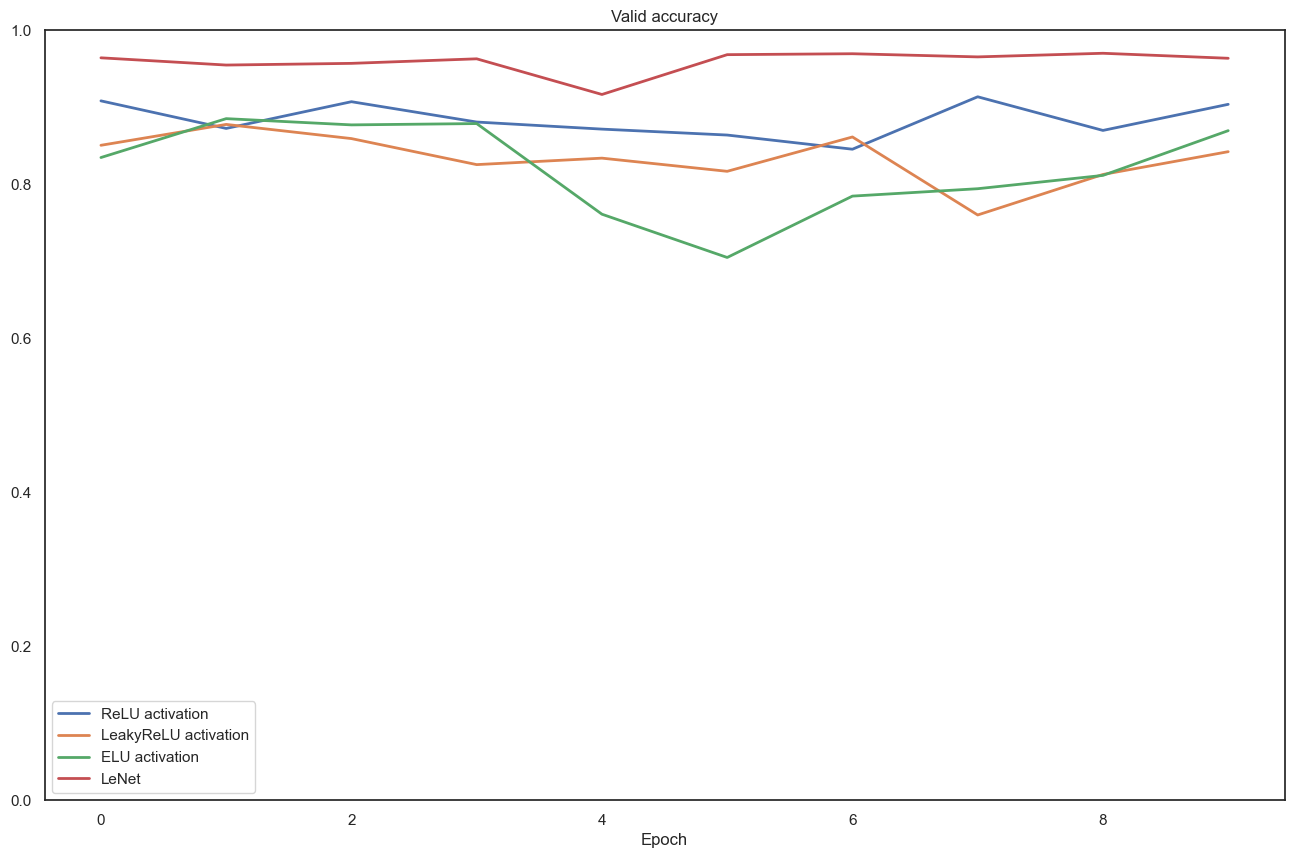

In [38]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.ylim([0, 1])
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.96